# Projet d'apprentissage semi-supervisé

__ModIA 2023__

__Etudiants__: Alexandre Personnic, Thi Minh Ha Ho

__Encadrant__: Axel Carlier

<h1 align="center"><font color='#964B00'>Table de matières</font></h1>
<div style="border-radius:10px; border:#DEB887 solid; background-color: #FFFAF0; font-size:100%; text-align:left">

1. [Introduction](#introduction)
2. [Importation et exploration de données](#data)
   
3. [Set-up de FixMatch](#paragraph1)

     * RandAugment 

     * Réseau fourni 

4. [Partie supervisée](#paragraph2)

5. [Partie semi-supervisée](#paragraph2)

In [1]:
# Obtenir des informations sur le GPU
!nvidia-smi

'nvidia-smi' is not recognized as an internal or external command,
operable program or batch file.


In [2]:
import tensorflow as tf
import imgaug.augmenters as iaa
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow import keras
import math
import os
import numpy as np
import json
import codecarbon

# Importation de données <a name="data"></a>

In [3]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()
y_train = tf.keras.utils.to_categorical(y_train)
y_test = tf.keras.utils.to_categorical(y_test)

NameError: name 'tf' is not defined

## RandAugment

Pour implémenter l'augmentation forte dans FixMatch, vous aurez besoin d'une politique d'augmentation de données apprise par renforcement. La méthode RandAugment a été implémentée dans la bibliothèque imgaug, voici comment l'utiliser

In [2]:
import imgaug.augmenters as iaa
aug = iaa.RandAugment(n=2, m=9)

def randaugment(img):
  return aug(images=img)

In [ ]:
aug(images=x_train[0])

NameError: name 'aug' is not defined

In [ ]:
# Application de RandAugment aux 4 premières images de la base d'entraînement
aug_img = randaugment(x_train[0:4])

# Affichage des images originales (ligne du haut) et augmentées (ligne du bas)
for i in range(4):
  plt.subplot(2,4,i+1)
  plt.imshow(x_train[i])

  plt.subplot(2,4, i+5)
  plt.imshow(aug_img[i])

AttributeError: module 'numpy' has no attribute 'bool'.
`np.bool` was a deprecated alias for the builtin `bool`. To avoid this error in existing code, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
The aliases was originally deprecated in NumPy 1.20; for more details and guidance see the original release note at:
    https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations

## Réseau fourni

Afin d'obtenir des résultats comparables, tout le monde devra utiliser le même réseau, que voici :

In [ ]:
def get_model():
    model = tf.keras.models.Sequential()
    model.add(tf.keras.layers.Normalization(input_shape=(32,32,3)))
    model.add(tf.keras.layers.Conv2D(32, (3,3), padding='same',activation='relu'))
    model.add(tf.keras.layers.MaxPooling2D(pool_size=(2,2)))
    model.add(tf.keras.layers.Conv2D(64, (3,3), padding='same', activation='relu'))
    model.add(tf.keras.layers.MaxPooling2D(pool_size=(2,2)))
    model.add(tf.keras.layers.Conv2D(96, (3,3), padding='same', activation='relu'))
    model.add(tf.keras.layers.MaxPooling2D(pool_size=(2,2)))
    model.add(tf.keras.layers.Conv2D(128, (3,3), padding='same', activation='relu'))
    model.add(tf.keras.layers.MaxPooling2D(pool_size=(2,2)))
    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(512,activation='relu'))
    model.add(tf.keras.layers.Dense(10,activation='softmax'))
    return model

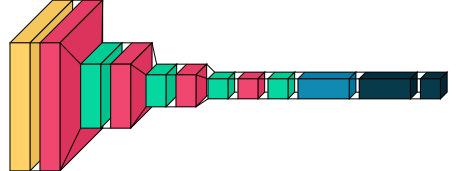

In [ ]:
import visualkeras

model = get_model()

visualkeras.layered_view(model, to_file='reseau_fourni.png') # write to disk

visualkeras.layered_view(model)

In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization_1 (Normalizat  (None, 32, 32, 3)        7         
 ion)                                                            
                                                                 
 conv2d_4 (Conv2D)           (None, 32, 32, 32)        896       
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 16, 16, 32)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 16, 16, 64)        18496     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 8, 8, 64)         0         
 2D)                                                             
                                                      

In [ ]:
def generate_dataset(sup_percent=1.0, random_state=None):
    """
    Retourne trois tuples de données et d'étiquettes : supervisé, non supervisé et test.
    
    sup_percent : Pourcentage de données supervisées. Doit être compris entre 0 et 1.
    """
    (x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()
    y_train = tf.keras.utils.to_categorical(y_train)
    y_test = tf.keras.utils.to_categorical(y_test)
    if sup_percent == 1.0:
        return (x_train, y_train), (None, None), (x_test, y_test)
    x_lab, x_unlab, y_lab, y_unlab = train_test_split(x_train, y_train, train_size=sup_percent, random_state=random_state)
    return (x_lab, y_lab), (x_unlab, y_unlab), (x_test, y_test)

# Partie supervisée

In [ ]:
# Tau d'apprentisage initial
eta = 0.03

# Momentum pour SGD
beta = 0.9

# Nombre d'epochs
sup_epoch = 1

In [ ]:
datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.125,
    height_shift_range=0.125,
    horizontal_flip=True,
    vertical_flip=True,
    shear_range=0.1,
    #brightness_range=(1,1),
    validation_split=0.2)

## Avec x% de données 

On a pris : x $\in$ [0.01, 0.05, 0.1, 1 ]

In [ ]:
sup_percent = 1 
(x_train, y_train), _, (x_test, y_test) = generate_dataset(sup_percent)
model = get_model()
model.compile(optimizer="adam",#tf.keras.optimizers.SGD(learning_rate=eta, momentum=beta, nesterov=True, weight_decay=5e-4),
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=['accuracy'])

In [ ]:
history = model.fit(
    datagen.flow(x_train, y_train, batch_size=128, subset='training'),
    validation_data=datagen.flow(x_train, y_train, batch_size=32, subset='validation'),
    epochs=sup_epoch,
    verbose=2)

313/313 - 42s - loss: 2.2392 - accuracy: 0.3092 - val_loss: 1.6355 - val_accuracy: 0.3860 - 42s/epoch - 135ms/step


In [ ]:
model.evaluate(x_test, y_test, batch_size=32, verbose=2)

313/313 - 3s - loss: 1.5876 - accuracy: 0.4172 - 3s/epoch - 8ms/step


[1.5875911712646484, 0.4171999990940094]

In [ ]:
model.save_weights(f"supervised/new_{sup_percent*100}_percent")

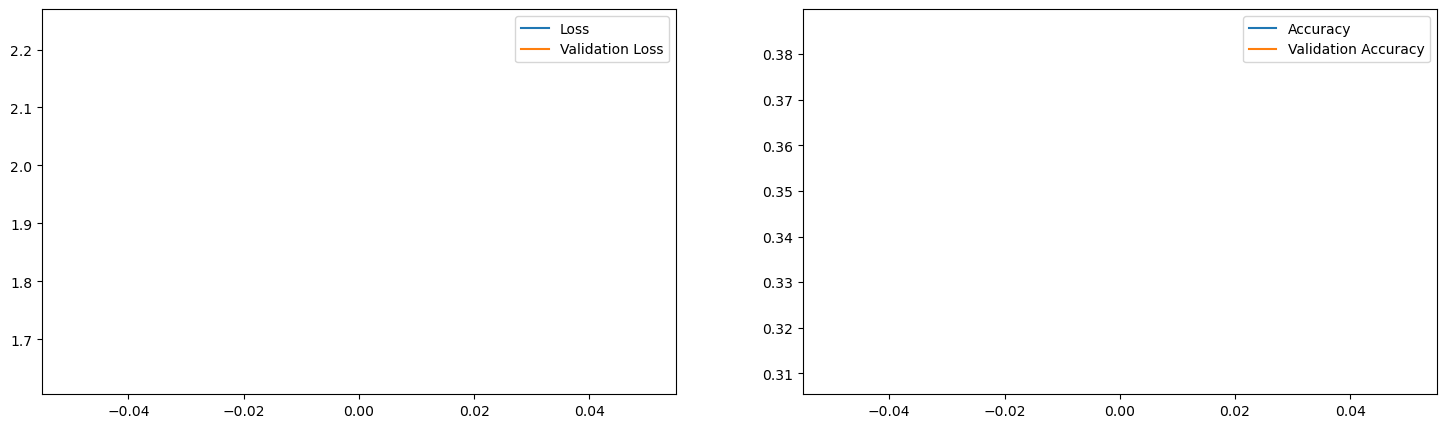

In [ ]:
plt.figure(figsize=(18,5))
plt.subplot(121)
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.legend(["Loss", "Validation Loss"])
plt.subplot(122)
plt.plot(history.history["accuracy"])
plt.plot(history.history["val_accuracy"])
plt.legend(["Accuracy", "Validation Accuracy"])
plt.show()

# Partie semi-supervisée

__Formule de la fonction de pert__


* La perte supervisée: 

\begin{equation}
    L_s=\frac{1}{B} \sum_{i=1}^B H\left(\ell_i, \mathbb{P}_{m}\left(\ell \mid \bm{\alpha}\left(x_i\right)\right)\right).
\end{equation}

* La perte non supervisée 

\begin{equation}
    L_u=\frac{1}{\mu B} \sum_{i = 1}^{\mu B} \mathbb{1}\left(\max \left(q_i\right) \geq \tau\right) H \left(\hat{q}_i, Q_i\right).
\end{equation}

* La perte totale: 

\begin{equation}
    L_{\rm total} = L_s + \lambda_u L_u
\end{equation}

In [ ]:
# Calcul de l'entropie de y_pred
def cross_entropy_loss_pseudo(y_pred_weak, y_pred_strong, tau):
    y_pred_weak_arg = tf.math.argmax(y_pred_weak, 1)
    y_pred_weak_arg = tf.keras.utils.to_categorical(y_pred_weak_arg, num_classes=10)
    y_pred_strong = tf.clip_by_value(y_pred_strong,1e-7, 1-1e-7)
    loss_obj = tf.keras.losses.CategoricalCrossentropy(reduction=tf.keras.losses.Reduction.NONE)
    entropy = loss_obj(y_pred_weak_arg, y_pred_strong)
    mask = tf.cast(tf.math.reduce_max(y_pred_weak, 1)>tau, y_pred_weak.dtype)
    nb_pseudo_label = tf.math.reduce_sum(mask)
    return tf.math.reduce_sum(tf.math.multiply(entropy, mask))*(1./y_pred_weak.shape[0]), int(nb_pseudo_label.numpy())

In [ ]:
@codecarbon.track_emissions(project_name="FixMatch", output_file="training_emissions.csv")
def training_loop(model, epochs, steps_per_epoch, x_train_lab, y_train_lab, x_train_unlab, x_test, y_test,
                 batch_size_lab, batch_size_unlab, history, weak_augment, strong_augment):
    # Indices de l'ensemble labellisé
    indices_lab = np.arange(x_train_lab.shape[0])
    indices_unlab = np.arange(x_train_unlab.shape[0])
    for epoch in range(epochs):
        # A chaque nouvelle epoch, on randomise les indices des différents ensembles
        np.random.shuffle(indices_lab)
        np.random.shuffle(indices_unlab)
        # Et on recommence à cumuler la loss
        cum_loss_value = 0
        cum_loss_sup = 0
        cum_loss_unsup = 0
        nb_pseudo_label_total = []

        for step in range(steps_per_epoch):#t_train:
            # Sélection des données du prochain batch
            x_batch_lab = x_train_lab[indices_lab[step*batch_size_lab: (step+1)*batch_size_lab]]
            x_batch_unlab = x_train_unlab[indices_unlab[step*batch_size_unlab: (step+1)*batch_size_unlab]]
            x_batch = np.concatenate((x_batch_lab, x_batch_unlab), axis=0)

            y_batch_lab = y_train_lab[indices_lab[step*batch_size_lab: (step+1)*batch_size_lab]]
            # Etape nécessaire pour comparer y_batch à la sortie du réseau
            y_batch = y_batch_lab #np.expand_dims(y_batch_lab, 1)

            # Les opérations effectuées par le modèle dans ce bloc sont suivies et permettront
            # la différentiation automatique.
            with tf.GradientTape() as tape:
                # Application du réseau aux données d'entrée
                x_batch_aug = weak_augment.flow(x_batch, shuffle=False, batch_size=batch_size).next()
                y_pred = model(x_batch_aug, training=True)  # Logits for this minibatch
                y_pred_aug = model(strong_augment(images=x_batch[batch_size_lab:]), training=True)
                
                # Partie supervisée : entropie croisée classique
                loss_sup = loss_s(y_batch, y_pred[:batch_size_lab])
                
                # Partie non supervisée : entropie !
                loss_unsup, nb_pseudo_label = cross_entropy_loss_pseudo(y_pred[batch_size_lab:], y_pred_aug, tau)
                nb_pseudo_label_total.append(nb_pseudo_label)
                loss_value = loss_sup + lambda_u*loss_unsup

                # Calcul des gradients par différentiation automatique
                grads = tape.gradient(loss_value, model.trainable_weights)

                # Réalisation d'une itération de la descente de gradient (mise à jour des paramètres du réseau)
                optimizer.apply_gradients(zip(grads, model.trainable_weights))

                # Mise à jour de la métrique
                train_acc_metric.update_state(y_batch, y_pred[:batch_size_lab])

                cum_loss_value += loss_value.numpy()
                cum_loss_sup += loss_sup.numpy()
                cum_loss_unsup += loss_unsup.numpy()
                
                # Calcul de la précision à la fin de l'epoch
                train_acc = train_acc_metric.result()
                
        # Calcul de la précision sur l'ensemble de test à la fin de l'epoch
        test_logits = model(x_test, training=False)
        test_acc_metric.update_state(np.expand_dims(y_test, 1), test_logits)
        test_acc = test_acc_metric.result()
        print(f"Epoch {epoch:3} : Accuracy = {train_acc.numpy():.4}, Test Accuracy = {test_acc.numpy():.4},\n\t    Loss = {cum_loss_value:.5}, Nb Pseudo Labels = {sum(nb_pseudo_label_total)} / {batch_size_unlab*steps_per_epoch}")
        history["loss_sup"].append(float(cum_loss_sup))
        history["loss_unsup"].append(float(cum_loss_unsup))
        history["loss_total"].append(float(cum_loss_value))
        history["acc"].append(float(train_acc.numpy()))
        history["test_acc"].append(float(test_acc.numpy()))
        history["nb_pseudo_label"].append(nb_pseudo_label_total)
        
        # Remise à zéro des métriques pour la prochaine epoch
        train_acc_metric.reset_states()
        test_acc_metric.reset_states()

In [ ]:
''' 
Définir hyper-paramètres 
'''

# Nombre d'epochs de l'apprentissage
epochs = 5

# Poids relatif de la régularisation non-supervisée
lambda_u = 1

# Tau d'apprentissage initial
eta = 0.03

# Momentum pour SGD
beta = 0.9

# Confiance minimale pour génération pseudo-label
tau = 0.95

# Facteur données non labellisées par batch
mu = 7

# Nombre de données labellisées par batch
batch_size_lab = 64

# Nombre de données non labellisées par batch
batch_size_unlab = batch_size_lab*mu

# Taille du batch
batch_size = batch_size_lab + batch_size_unlab

## Avec x% des données aléatoires 

In [ ]:
percent = 0.1
per_int = int(percent*100)
test = generate_dataset(percent, random_state=31415)

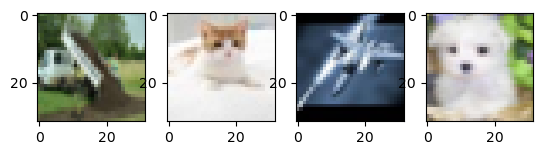

In [ ]:
# Affichage des images originales
for i in range(4):
  plt.subplot(2,4,i+1)
  plt.imshow(test[0][0][i])

In [ ]:
(x_train_lab, y_train_lab), (x_train_unlab, y_train_unlab), (x_test, y_test) = generate_dataset(percent, random_state=31415)

if batch_size_lab < x_train_lab.shape[0]:
    steps_per_epoch = math.floor(x_train_lab.shape[0]/batch_size_lab)
else:
    steps_per_epoch = 1
    batch_size_lab = x_train_lab.shape[0]
    
# Nombre de pas d'entrainement
K = steps_per_epoch * epochs # 2**10 # 2**20


weak_augment = tf.keras.preprocessing.image.ImageDataGenerator(
    horizontal_flip=True,
    width_shift_range=0.125,
    height_shift_range=0.125,
    fill_mode='reflect'
)

strong_augment = iaa.RandAugment(n=2, m=15)

# Instanciation d'un optimiseur et d'une fonction de coût.
optimizer = keras.optimizers.Adam(learning_rate=1e-4)
#optimizer = keras.optimizers.SGD(learning_rate=eta, momentum=beta, nesterov=True, weight_decay=5e-4)
loss_s = keras.losses.CategoricalCrossentropy()

model = get_model()
model.compile(optimizer=optimizer,
              loss=loss_s,
              metrics=['accuracy'])

# Préparation des métriques pour le suivi de la performance du modèle.
train_acc_metric = keras.metrics.CategoricalAccuracy()
test_acc_metric = keras.metrics.CategoricalAccuracy()

In [ ]:
''' 
Charger les poids de notre modèle 
'''
load_checkpoint = True
if load_checkpoint:
    model.load_weights(f"results_random_images/fixmatch/{per_int}_percent")
    epochs = 1 # Just to verify model well trained 

In [ ]:
''' 
Chargement de HISTORY 
'''

if load_checkpoint:
    with open(f"results_random_images/fixmatch/{per_int}_percent_history.json", 'r') as file:
        history = json.load(file)
else:
    history = {"loss_sup": [], "loss_unsup": [], "loss_total": [], "acc": [], "test_acc": [], "nb_pseudo_label": []}

In [ ]:
''' 
Précision avant (RE)TRAINING
'''
model.evaluate(x_test, y_test, batch_size=32, verbose=2)

313/313 - 3s - loss: 1.6623 - accuracy: 0.4111 - 3s/epoch - 9ms/step


[1.662337303161621, 0.41110000014305115]

In [ ]:
training_loop(model, epochs, steps_per_epoch, x_train_lab, y_train_lab, x_train_unlab, x_test, y_test,
                 batch_size_lab, batch_size_unlab, history, weak_augment, strong_augment)

[codecarbon INFO @ 16:56:10] [setup] RAM Tracking...
[codecarbon INFO @ 16:56:10] [setup] GPU Tracking...
[codecarbon INFO @ 16:56:10] No GPU found.
[codecarbon INFO @ 16:56:10] [setup] CPU Tracking...
[codecarbon WARNING @ 16:56:10] No CPU tracking mode found. Falling back on CPU constant mode.
[codecarbon WARNING @ 16:56:13] We saw that you have a AMD Ryzen 5 PRO 4650U with Radeon Graphics but we don't know it. Please contact us.
[codecarbon INFO @ 16:56:13] CPU Model on constant consumption mode: AMD Ryzen 5 PRO 4650U with Radeon Graphics
[codecarbon INFO @ 16:56:13] >>> Tracker's metadata:
[codecarbon INFO @ 16:56:13]   Platform system: Windows-10-10.0.19044-SP0
[codecarbon INFO @ 16:56:13]   Python version: 3.8.16
[codecarbon INFO @ 16:56:13]   CodeCarbon version: 2.2.4
[codecarbon INFO @ 16:56:13]   Available RAM : 15.329 GB
[codecarbon INFO @ 16:56:13]   CPU count: 12
[codecarbon INFO @ 16:56:13]   CPU model: AMD Ryzen 5 PRO 4650U with Radeon Graphics
[codecarbon INFO @ 16:56:13

Epoch   0 : Accuracy = 0.9958, Test Accuracy = 0.7396,
	    Loss = 21.279, Nb Pseudo Labels = 22516 / 34944


[codecarbon INFO @ 16:57:46] Energy consumed for RAM : 0.000144 kWh. RAM Power : 5.7485246658325195 W
[codecarbon INFO @ 16:57:46] Energy consumed for all CPUs : 0.001063 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 16:57:46] 0.001206 kWh of electricity used since the beginning.
[codecarbon INFO @ 16:58:01] Energy consumed for RAM : 0.000168 kWh. RAM Power : 5.7485246658325195 W
[codecarbon INFO @ 16:58:01] Energy consumed for all CPUs : 0.001240 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 16:58:01] 0.001408 kWh of electricity used since the beginning.
[codecarbon INFO @ 16:58:16] Energy consumed for RAM : 0.000192 kWh. RAM Power : 5.7485246658325195 W
[codecarbon INFO @ 16:58:16] Energy consumed for all CPUs : 0.001417 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 16:58:16] 0.001609 kWh of electricity used since the beginning.
[codecarbon INFO @ 16:58:31] Energy consumed for RAM : 0.000215 kWh. RAM Power : 5.7485246658325195 W
[codecarbon INFO @ 16:58:31] Energy consumed f

Epoch   1 : Accuracy = 0.9952, Test Accuracy = 0.735,
	    Loss = 21.56, Nb Pseudo Labels = 22467 / 34944


[codecarbon INFO @ 16:59:02] Energy consumed for RAM : 0.000263 kWh. RAM Power : 5.7485246658325195 W
[codecarbon INFO @ 16:59:02] Energy consumed for all CPUs : 0.001949 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 16:59:02] 0.002212 kWh of electricity used since the beginning.
[codecarbon INFO @ 16:59:16] 
Graceful stopping: collecting and writing information.
Please wait a few seconds...
[codecarbon INFO @ 16:59:16] Energy consumed for RAM : 0.000287 kWh. RAM Power : 5.7485246658325195 W
[codecarbon INFO @ 16:59:16] Energy consumed for all CPUs : 0.002124 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 16:59:16] 0.002411 kWh of electricity used since the beginning.
[codecarbon INFO @ 16:59:16] Done!



KeyboardInterrupt: 

In [ ]:
''' 
Précision après (RE)TRAINING
'''
model.evaluate(x_test, y_test, batch_size=32, verbose=2)

313/313 - 2s - loss: 1.1825 - accuracy: 0.7399 - 2s/epoch - 8ms/step


[1.1824804544448853, 0.7398999929428101]

In [ ]:
save_model = False  
if save_model:
    model.save_weights(f"unsupervised/{per_int}_percent")

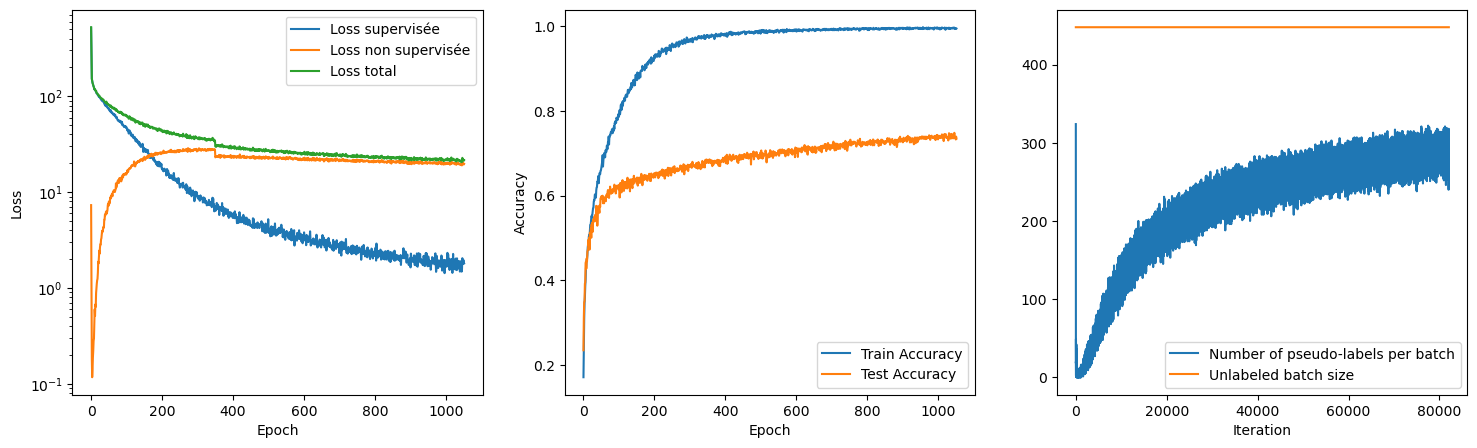

In [ ]:
plt.figure(figsize=(18,5))
plt.subplot(131)
plt.semilogy(history["loss_sup"])
plt.semilogy(history["loss_unsup"])
plt.semilogy(history["loss_total"])
plt.legend(["Loss supervisée", "Loss non supervisée", "Loss total"])
plt.xlabel("Epoch")
plt.ylabel("Loss")

plt.subplot(132)
plt.plot(history["acc"])
plt.plot(history["test_acc"])
plt.legend(["Train Accuracy", "Test Accuracy"])
plt.xlabel("Epoch")
plt.ylabel("Accuracy")

plt.subplot(133)
flattened = [item for sublist in history["nb_pseudo_label"] for item in sublist]
plt.plot(flattened)
plt.plot([batch_size_unlab]*len(flattened))
plt.legend(["Number of pseudo-labels per batch", "Unlabeled batch size"])
plt.xlabel("Iteration")
plt.show()

## Avec x% des données choisies  

In [ ]:
''' 
Importer les images uniques 
'''
path = 'unique-cifar10-images/'

percent = 0.05
per_int = int(percent*100)

test = np.load(path +f'X_unique_{per_int}.npy')
test_y = np.load(path +f'y_unique_{per_int}.npy')
test_y = tf.keras.utils.to_categorical(test_y)

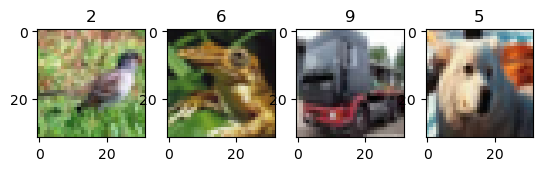

In [ ]:
# Affichage des images originales
for i in range(4):
    plt.subplot(2,4,i+1)
    plt.imshow(test[i])
    plt.title(test_y[i].argmax())

In [ ]:
(x_train_lab, y_train_lab), (x_train_unlab, y_train_unlab), (x_test, y_test) = generate_dataset(sup_percent=0.1)

# Charger les images uniques 
x_train_lab, y_train_lab =  np.load(path + f'X_unique_{per_int}.npy'), np.load(path +f'y_unique_{per_int}.npy')
y_train_lab = tf.keras.utils.to_categorical(y_train_lab)

if batch_size_lab < x_train_lab.shape[0]:
    steps_per_epoch = math.floor(x_train_lab.shape[0]/batch_size_lab)
else:
    steps_per_epoch = 1
    batch_size_lab = x_train_lab.shape[0]
    
# Nombre de pas d'entrainement
K = steps_per_epoch * epochs # 2**10 # 2**20


weak_augment = tf.keras.preprocessing.image.ImageDataGenerator(
    horizontal_flip=True,
    width_shift_range=0.125,
    height_shift_range=0.125,
    fill_mode='reflect'
)

strong_augment = iaa.RandAugment(n=2, m=15)

# Instanciation d'un optimiseur et d'une fonction de coût.
optimizer = keras.optimizers.Adam(learning_rate=1e-4)
#optimizer = keras.optimizers.SGD(learning_rate=eta, momentum=beta, nesterov=True, weight_decay=5e-4)
loss_s = keras.losses.CategoricalCrossentropy()

model = get_model()
model.compile(optimizer=optimizer,
              loss=loss_s,
              metrics=['accuracy'])

# Préparation des métriques pour le suivi de la performance du modèle.
train_acc_metric = keras.metrics.CategoricalAccuracy()
test_acc_metric = keras.metrics.CategoricalAccuracy()

In [ ]:
load_checkpoint = True
if load_checkpoint:
    model.load_weights(f"results_unique_images/unsupervised/{per_int}_percent/{per_int}_percent_unique")
    with open(f"results_unique_images/unsupervised/{per_int}_percent/{per_int}_percent_unique_history.json", 'r') as file:
        history = json.load(file)
    epochs = 1 # 2 
else:
    history = {"loss_sup": [], "loss_unsup": [], "loss_total": [], "acc": [], "test_acc": [], "nb_pseudo_label": []}

In [ ]:
''' 
Précision avant (RE)TRAINING
'''
model.evaluate(x_test, y_test, batch_size=32, verbose=2)

313/313 - 3s - loss: 1.6762 - accuracy: 0.6689 - 3s/epoch - 9ms/step


[1.6761603355407715, 0.6689000129699707]

In [ ]:
training_loop(model, epochs, steps_per_epoch, x_train_lab, y_train_lab, x_train_unlab, x_test, y_test,
                 batch_size_lab, batch_size_unlab, history, weak_augment, strong_augment)

[codecarbon INFO @ 17:38:20] [setup] RAM Tracking...
[codecarbon INFO @ 17:38:20] [setup] GPU Tracking...
[codecarbon INFO @ 17:38:20] No GPU found.
[codecarbon INFO @ 17:38:20] [setup] CPU Tracking...
[codecarbon WARNING @ 17:38:20] No CPU tracking mode found. Falling back on CPU constant mode.


[codecarbon WARNING @ 17:38:23] We saw that you have a AMD Ryzen 5 PRO 4650U with Radeon Graphics but we don't know it. Please contact us.
[codecarbon INFO @ 17:38:23] CPU Model on constant consumption mode: AMD Ryzen 5 PRO 4650U with Radeon Graphics
[codecarbon INFO @ 17:38:23] >>> Tracker's metadata:
[codecarbon INFO @ 17:38:23]   Platform system: Windows-10-10.0.19044-SP0
[codecarbon INFO @ 17:38:23]   Python version: 3.8.16
[codecarbon INFO @ 17:38:23]   CodeCarbon version: 2.2.4
[codecarbon INFO @ 17:38:23]   Available RAM : 15.329 GB
[codecarbon INFO @ 17:38:23]   CPU count: 12
[codecarbon INFO @ 17:38:23]   CPU model: AMD Ryzen 5 PRO 4650U with Radeon Graphics
[codecarbon INFO @ 17:38:23]   GPU count: None
[codecarbon INFO @ 17:38:23]   GPU model: None


Unexpected exception formatting exception. Falling back to standard exception


Traceback (most recent call last):
  File "c:\Users\THOOT38J\Anaconda3\envs\deep_learning\lib\site-packages\IPython\core\interactiveshell.py", line 3398, in run_code
    nnode = ast.Expr(ast.Name(target.id, ast.Load()))
  File "C:\Temp\ipykernel_8592\2016088627.py", line 1, in <cell line: 1>
    training_loop(model, epochs, steps_per_epoch, x_train_lab, y_train_lab, x_train_unlab, x_test, y_test,
  File "c:\Users\THOOT38J\Anaconda3\envs\deep_learning\lib\site-packages\codecarbon\emissions_tracker.py", line 865, in wrapped_fn
    tracker = EmissionsTracker(
  File "c:\Users\THOOT38J\Anaconda3\envs\deep_learning\lib\site-packages\codecarbon\emissions_tracker.py", line 346, in __init__
    self._geo = self._get_geo_metadata()
  File "c:\Users\THOOT38J\Anaconda3\envs\deep_learning\lib\site-packages\codecarbon\emissions_tracker.py", line 753, in _get_geo_metadata
    return GeoMetadata.from_geo_js(self._data_source.geo_js_url)
  File "c:\Users\THOOT38J\Anaconda3\envs\deep_learning\lib\site-

In [ ]:
''' 
Précision après (RE)TRAINING
'''
model.evaluate(x_test, y_test, batch_size=32, verbose=2)

313/313 - 2s - loss: 2.2552 - accuracy: 0.5811 - 2s/epoch - 8ms/step


[2.255227565765381, 0.5810999870300293]

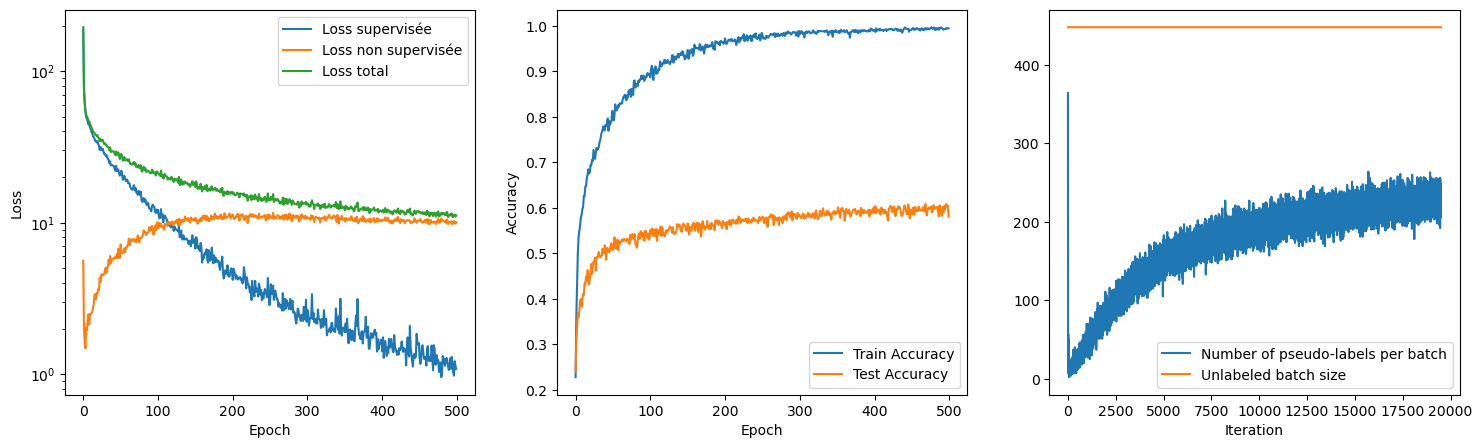

In [ ]:
plt.figure(figsize=(18,5))
plt.subplot(131)
plt.semilogy(history["loss_sup"])
plt.semilogy(history["loss_unsup"])
plt.semilogy(history["loss_total"])
plt.legend(["Loss supervisée", "Loss non supervisée", "Loss total"])
plt.xlabel("Epoch")
plt.ylabel("Loss")

plt.subplot(132)
plt.plot(history["acc"])
plt.plot(history["test_acc"])
plt.legend(["Train Accuracy", "Test Accuracy"])
plt.xlabel("Epoch")
plt.ylabel("Accuracy")

plt.subplot(133)
flattened = [item for sublist in history["nb_pseudo_label"] for item in sublist]
plt.plot(flattened)
plt.plot([batch_size_unlab]*len(flattened))
plt.legend(["Number of pseudo-labels per batch", "Unlabeled batch size"])
plt.xlabel("Iteration")
plt.show()